# Download data

In [15]:
import gdown
file_id = "1V8xukCZYfdArv-OXtDx7fSMdo_E1hT8E"

gdown.download(f"https://drive.google.com/uc?export=download&id={file_id}", "digit-reconizer.zip", quiet=False)

Downloading...
From: https://drive.google.com/uc?export=download&id=1V8xukCZYfdArv-OXtDx7fSMdo_E1hT8E
To: d:\University\Natural Language Processing (NLP)\Exercise class\Week 8\Homework\digit-reconizer.zip
100%|██████████| 16.1M/16.1M [00:01<00:00, 10.1MB/s]


'digit-reconizer.zip'

In [16]:
import zipfile
import os

curr_path = os.getcwd()

os.makedirs(f"{curr_path}/data", exist_ok=True)

zip_file_name = f"{curr_path}/digit-reconizer.zip"
with zipfile.ZipFile(zip_file_name, "r") as zip_ref:
    zip_ref.extractall(f"{curr_path}/data")

print(f"Files extracted to {curr_path}/data")

Files extracted to d:\University\Natural Language Processing (NLP)\Exercise class\Week 8\Homework/data


# Library

In [17]:
import os
import shutil
import pandas as pd
import numpy as np
import zipfile
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

In [18]:
input_path = f"{curr_path}/data"

In [19]:
train_df = pd.read_csv(f"{input_path}/train.csv")
test_df = pd.read_csv(f"{input_path}/test.csv")

In [20]:
print(train_df[:1])

   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   

   pixel8  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
0       0  ...         0         0         0         0         0         0   

   pixel780  pixel781  pixel782  pixel783  
0         0         0         0         0  

[1 rows x 785 columns]


In [21]:
train_df.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


In [22]:
train_df['label'].unique()

array([1, 0, 4, 7, 3, 5, 8, 9, 2, 6])

In [23]:
train_df.shape

(42000, 785)

# Train model

## Model 2

In [24]:
%%time
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
# Preprocess data
X = train_df.iloc[:, 1:].values / 255.0  # Normalize pixel values
y = train_df.iloc[:, 0].values           # Labels

# Train-validation split (80-20)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=50)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=batch_size, shuffle=False)

# Define the MLP model using nn.Sequential
class MLPModel(nn.Module):
    def __init__(self, input_size=784, hidden_size=[1024], output_size=10):
        super(MLPModel, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size[0]),
            nn.BatchNorm1d(hidden_size[0]),
            nn.SiLU(),
            nn.Dropout(0.4),
           
            nn.Linear(hidden_size[0], hidden_size[0]),
            nn.BatchNorm1d(hidden_size[0]),
            nn.LeakyReLU(negative_slope=0.03),
            nn.Dropout(0.4),

            nn.Linear(hidden_size[0], hidden_size[0]),
            nn.BatchNorm1d(hidden_size[0]),
            nn.ReLU(),
            nn.Dropout(0.4),
            
            nn.Linear(hidden_size[0], hidden_size[0]),
            nn.BatchNorm1d(hidden_size[0]),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(hidden_size[0], hidden_size[0]),
            nn.BatchNorm1d(hidden_size[0]),
            nn.LeakyReLU(negative_slope=0.03),
            nn.Dropout(0.4),

            nn.Linear(hidden_size[0], hidden_size[0]),
            nn.BatchNorm1d(hidden_size[0]),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(hidden_size[0], output_size),
        )

    def forward(self, x):
        return self.model(x)

Using device: cuda
CPU times: total: 328 ms
Wall time: 771 ms


In [25]:
%%time
# Initialize model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLPModel().to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.RAdam(model.parameters(), lr=0.001, betas=(0.9, 0.9999), weight_decay=1e-5)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.8, patience=5)

# Training loop with best model saving
num_epochs = 200
patience = 200  
best_val_loss = float("inf")  
best_val_acc = 0.0
model_path = "best_mlp_digit_recognizer.pth"
epochs_no_improve = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    avg_train_loss = running_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0.0
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct / total

    current_lr = optimizer.param_groups[0]['lr']
    scheduler.step(avg_val_loss)
    new_lr = optimizer.param_groups[0]['lr']
    if new_lr < current_lr:
        print(f"📘 Learning rate reduced from {current_lr:.6f} to {new_lr:.6f}")
    
    # Check if validation loss improved
    if val_accuracy > best_val_acc:
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy 
        torch.save(model.state_dict(), model_path)
        print(f"✅ Epoch {epoch+1}: Validation loss improved to {best_val_loss:.4f}. Model saved!")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        print(f"⚠️ No improvement in validation accuracy for {epochs_no_improve} epochs.")

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

    # Stop training if no improvement for 'patience' epochs
    if epochs_no_improve >= patience:
        print("🚨 Early stopping triggered! Loading best model...")
        break

# Load the best model
model.load_state_dict(torch.load(model_path))
print(f"🎯 Best model loaded with Val Loss: {best_val_loss:.4f}")

✅ Epoch 1: Validation loss improved to 0.7896. Model saved!
Epoch [1/200], Train Loss: 1.3418, Val Loss: 0.7896, Val Acc: 92.49%
✅ Epoch 2: Validation loss improved to 0.6768. Model saved!
Epoch [2/200], Train Loss: 0.7591, Val Loss: 0.6768, Val Acc: 95.05%
✅ Epoch 3: Validation loss improved to 0.6141. Model saved!
Epoch [3/200], Train Loss: 0.6869, Val Loss: 0.6141, Val Acc: 96.61%
✅ Epoch 4: Validation loss improved to 0.5918. Model saved!
Epoch [4/200], Train Loss: 0.6526, Val Loss: 0.5918, Val Acc: 97.00%
✅ Epoch 5: Validation loss improved to 0.5783. Model saved!
Epoch [5/200], Train Loss: 0.6329, Val Loss: 0.5783, Val Acc: 97.29%
⚠️ No improvement in validation accuracy for 1 epochs.
Epoch [6/200], Train Loss: 0.6154, Val Loss: 0.5824, Val Acc: 96.95%
✅ Epoch 7: Validation loss improved to 0.5584. Model saved!
Epoch [7/200], Train Loss: 0.6086, Val Loss: 0.5584, Val Acc: 97.89%
⚠️ No improvement in validation accuracy for 1 epochs.
Epoch [8/200], Train Loss: 0.5981, Val Loss: 0.

<timed exec>:80: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


In [26]:
%%time
model = MLPModel().to(device) 
model.load_state_dict(torch.load(model_path))
model.eval()

correct, total = 0, 0
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Validation Accuracy: {100 * correct / total:.2f}%")

<timed exec>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


Validation Accuracy: 98.83%
CPU times: total: 78.1 ms
Wall time: 303 ms


# Submission

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
X_test = test_df.values / 255.0 
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

with torch.no_grad():
    test_outputs = model(X_test_tensor)
    predictions = torch.argmax(test_outputs, dim=1).cpu().numpy()  # Convert to numpy array

# Save predictions to submission.csv (for Kaggle)
submission = pd.DataFrame({"ImageId": np.arange(1, len(predictions) + 1), "Label": predictions})
submission.to_csv("submission.csv", index=False)
print("Predictions saved to submission.csv!")

Using device: cuda
Predictions saved to submission.csv!


In [28]:
print(submission.head())

   ImageId  Label
0        1      2
1        2      0
2        3      9
3        4      9
4        5      3


# Get submission image
### In my code, I use some Dropout in the layers, so the result may fluctuate. But have make the random seed to be constant in splitting train and validate dataset

Downloading...
From: https://drive.google.com/uc?export=download&id=1Hj2CEPjhNd8whkkfo3_i5ejSC1e2XL1P
To: d:\University\Natural Language Processing (NLP)\Exercise class\Week 8\Homework\Digit_submission.png
100%|██████████| 15.7k/15.7k [00:00<00:00, 796kB/s]


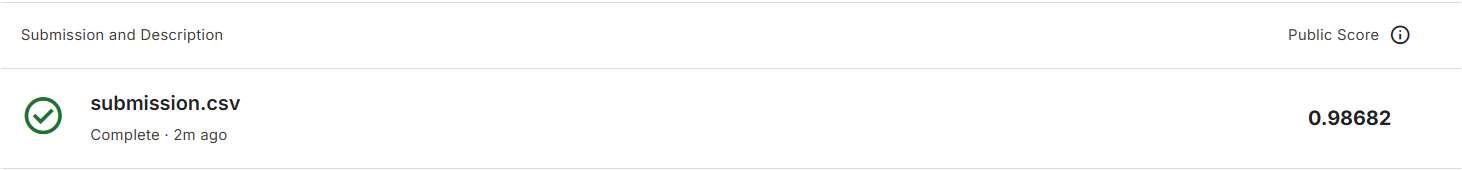

In [29]:
import gdown
import IPython.display as display
from PIL import Image

file_id = "1Hj2CEPjhNd8whkkfo3_i5ejSC1e2XL1P"
image_path = "Digit_submission.png"

gdown.download(f"https://drive.google.com/uc?export=download&id={file_id}", image_path, quiet=False)

image = Image.open(image_path)
display.display(image)


# Get ranking image

Downloading...
From: https://drive.google.com/uc?export=download&id=1GiWJLkGM4gHQF5kYL7bV_n3mwk_Xdlhu
To: d:\University\Natural Language Processing (NLP)\Exercise class\Week 8\Homework\Ranking_ranking.png
100%|██████████| 15.7k/15.7k [00:00<00:00, 829kB/s]


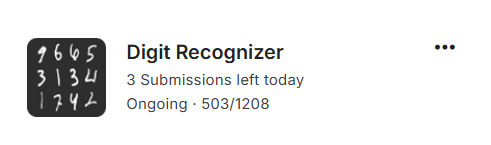

In [30]:
import gdown
import IPython.display as display
from PIL import Image

file_id = "1GiWJLkGM4gHQF5kYL7bV_n3mwk_Xdlhu"
image_path = "Ranking_ranking.png"

gdown.download(f"https://drive.google.com/uc?export=download&id={file_id}", image_path, quiet=False)

image = Image.open(image_path)
display.display(image)
